# Univariate ARIMA Prediction - single asset
## 1. Load libraries

In [1]:
#import libraries
import pandas as pd
from pandas import DataFrame 
from pandas.plotting import lag_plot
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 18,10
%matplotlib inline

#import itertools
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import acf, pacf, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
import numpy as np
from numpy import log

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn import datasets

#from io import StringIO
import time, json

rcParams['figure.figsize'] = 18,10

import warnings 
warnings.filterwarnings('ignore')

## 2. Load and visualize time series dataset
### 2.1 Load data
Asset data of weekly frequency named xxx.csv is downloaded from Yahoo Finance UK (or API??) is loaded into the notebook by the def GetData function. The loaded data is presented as a float32 datatype in a DataFrame format.

In [2]:
%store -r data_GLD


In [3]:
#Developed market ETF
data_GLD.columns = ['Adj_Close']
data_GLD.head()


,Adj_Close
Date,
2009-06-01,93.709999
2009-06-08,92.169998
2009-06-15,91.900002
2009-06-22,92.290001
2009-06-29,91.250000


### 2.2 Visualize time series trend graph
Depict how EFA trends over time and highlight the separation of testing and training periods.

In [4]:
#Statistical info on MCD
data_GLD.describe()

,Adj_Close
count,522.000000
mean,127.313370
std,19.082916
min,89.580002
25%,115.502499
50%,122.230000
75%,133.654995
max,183.240005


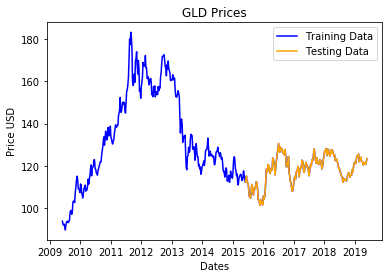

In [6]:
# !! shading !! ##

#Divide data into training and testing
train_data, test_data = data_GLD[0:int(len(data_GLD)*0.4)], data_GLD[int(len(data_GLD)*0.6):]
#plt.figure(figsize=(12,7))
plt.title('GLD Prices')
plt.xlabel('Dates')
plt.ylabel('Price USD')
plt.plot(data_GLD['Adj_Close'], 'blue', label='Training Data')
plt.plot(test_data['Adj_Close'], 'orange', label='Testing Data')
#plt.xticks(np.arange(0,7982, 1300), data_MCD_df['Date'][0:7982:1300])
plt.legend()

## 3. Data Preprocessing
1. Autocorrelation visualization
2. Stationarity checks
2. Scale data if needs be
3. Trend removal

### 3.1 Auto correlation checks

Text(0.5, 1.0, 'GLD Autocorrelation Plot')

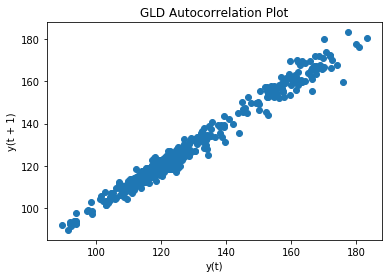

In [7]:
#analyze autocorr plot to see if ARIMA is necessary
#https://towardsdatascience.com/stock-market-analysis-using-arima-8731ded2447a

plt.figure()
lag_plot(data_GLD, lag=1)
plt.title('GLD Autocorrelation Plot')

### 3.2 Stationarity checks
[IBM Watson Studio - time series predition](https://dataplatform.cloud.ibm.com/exchange/public/entry/view/815137c868b916821dec777bdc23013c)

"In a stationary time series, the statistical properties over time must be constant and autoconvariance must be time independent. Normally, when running a regular regression, you expect the observations to be independent of each other. In a time series, however, you know that the observations are time dependent. In order to use regression techniques on time dependent variables, the data must be stationary. The techniques that apply to independent random variables also apply to stationary random variables.

There are two ways to check the stationarity of a time series. The first is plot the moving variance and observe if it remains constant over time. However, you might not always be able to make such visual inferences. The second way is to use the Dickey-Fuller test, a statistical test with the null hypothesis that the time series is non-stationary. If the test results in the test statistic significantly less than the critical values, we can reject the null hypothesis in favor of time series stationarity.

Calculate the moving variances, plot the results and apply the Dickey-Fuller test on the time series:"


In [8]:
#Perform rolling statistics & Dickey-Fuller test:

def stationarity_test(timeseries):
    
    rolling_mean = timeseries.rolling(52).mean()
    rolling_std = timeseries.rolling(52).std()    
    
    #Plot rolling statistics:
    original = plt.plot(timeseries.index.to_pydatetime(), timeseries.values, color='blue',label='Original')
    mean = plt.plot(rolling_mean.index.to_pydatetime(), rolling_mean.values, color='red', label='Rolling Mean')
    std = plt.plot(rolling_std.index.to_pydatetime(), rolling_std.values, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

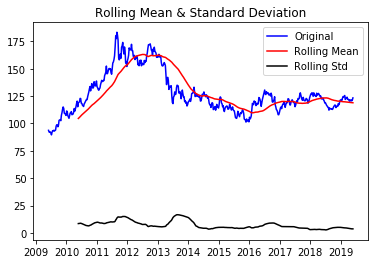

Results of Dickey-Fuller Test:
Test Statistic                  -2.262196
p-value                          0.184451
#Lags Used                       1.000000
Number of Observations Used    520.000000
Critical Value (1%)             -3.442988
Critical Value (5%)             -2.867114
Critical Value (10%)            -2.569739
dtype: float64


In [9]:
stationarity_test(data_GLD.iloc[:,0])

From the D-F test:
* p-value = 0.04 < 0.05 
* Reject Ho
* Time series is stationary.
* No transformation required. 

## 4. Stationarization of time series
In the event of a trend or seasonality appearing on the time series data, rectifying measures can be performed through calculating and removing the trend and seasonality from the model.  
[Duke: what data transformation to apply](http://people.duke.edu/~rnau/whatuse.htm)

### 4.1 Apply non-linear log transformation
For the checking of stationarity

In [10]:
data_GLD_log = np.log(data_GLD)

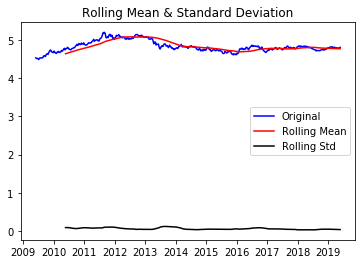

Results of Dickey-Fuller Test:
Test Statistic                  -2.462431
p-value                          0.124885
#Lags Used                       1.000000
Number of Observations Used    520.000000
Critical Value (1%)             -3.442988
Critical Value (5%)             -2.867114
Critical Value (10%)            -2.569739
dtype: float64


In [11]:
stationarity_test(data_GLD_log.iloc[:,0])

(insert comment for p-value)

### 4.2 De-trend with decomposition
This step concerns the removal of trends and seasonalities from the time series data. Decomposition shows whether results reveals an increasing trend to seasonal effect in yearly cycles.

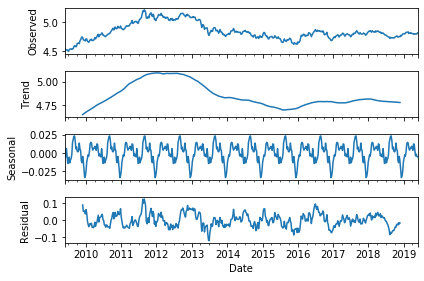

<Figure size 1440x720 with 0 Axes>

In [12]:
#Seasonality & decompo
decomposition = sm.tsa.seasonal_decompose(data_GLD_log)
fig = decomposition.plot()
plt.figure(figsize=(20, 10))
plt.show()

Seasonal information extracted shows ... 

### 4.3 Differencing (removal of trends and seasonalities)
First differencing allows the computation of differences between t and t-1. Differencing results to be confirmed by D-F test.

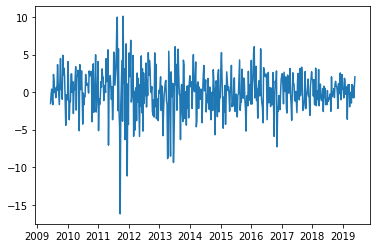

In [13]:
# differencing w/o log
GLD_diff = data_GLD - data_GLD.shift()
GLD_diff.dropna()
plt.plot(GLD_diff)

#GLD_diff = data_GLD - data_GLD.shift()
#plt.plot(ts_euro_week_log_diff.index.to_pydatetime(), ts_euro_week_log_diff.values)


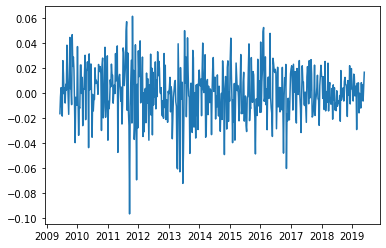

In [14]:
# diff w log
GLD_log_diff = data_GLD_log - data_GLD_log.shift()
GLD_log_diff.dropna()
plt.plot(GLD_log_diff)


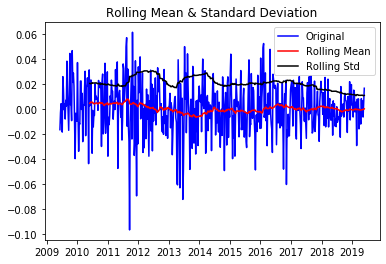

Results of Dickey-Fuller Test:
Test Statistic                 -21.149468
p-value                          0.000000
#Lags Used                       0.000000
Number of Observations Used    520.000000
Critical Value (1%)             -3.442988
Critical Value (5%)             -2.867114
Critical Value (10%)            -2.569739
dtype: float64


In [15]:
GLD_log_diff.dropna(inplace=True)
stationarity_test(GLD_log_diff.iloc[:,0])

Since test-stats is less than 1% critical value. It is with 99% confidence that the time series has statisfied the stationarity condition. ARIMA forecast can proceed using the stationarized data.

## 5. Building ARIMA(p,d,q) model 
1. Find optimal p,d,q parameters to build the ARIMA model.

"
* The number of autoregressive (AR) terms (p): AR terms are just lags of the dependent variable, the euro rate, in this case. So, if p=2, it means that predictors of x(t) will be x(t-1) and x(t-2).
* The number of moving average (MA) terms (q): MA terms are lagged forecast errors in the prediction equation. For instance, if q=2, the predictors for x(t) will be e(t-1) and e(t-2) where e(i) is the difference between the moving average at i-th instant and the actual value.
* The number of differences (d): These are the number of non-seasonal differences. In your case, d=1, as you are modeling using the first order differenced time series.
"
"
There are two ways to determine the number of AR and MA terms. The first is to use the arma_order_select_ic function in Python. The second uses plots of the autocorrelation function (ACF) and partial autocorrelation function (PACF).

This article describes in detail the purpose of the ACF and PACF plots.
"
[Visit IBM](https://dataplatform.cloud.ibm.com/exchange/public/entry/view/815137c868b916821dec777bdc23013c)

### 5.1 Plotting autocorrelation function (ACF)
To determine the values for p, d, q
(merely using data without long-transformation does not converge data)

In [16]:
lag_acf = acf(GLD_log_diff, nlags=10)
lag_pacf = pacf(GLD_log_diff, nlags=10, method='ols')

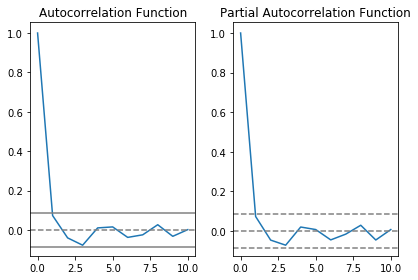

In [17]:
#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(GLD_log_diff)),linestyle='-',color='gray')
plt.axhline(y=1.96/np.sqrt(len(GLD_log_diff)),linestyle='-',color='gray')
plt.title('Autocorrelation Function')

#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(GLD_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(GLD_log_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

In the above plots, 'p' and 'q' can be determined as:
"
p: The lag value where the PACF cuts off (drops to 0) crosses 0 from above for the first time. Therefore, p=2.
q: The lag value where the ACF chart crosses the upper confidence interval for the first time. If you look closely, q=2.
This means that the optimal values for the ARIMA(p,d,q) model are (2,1,2).

If your assessment of the ACF and PACF plots differs from the values suggested by the arma_order_select_ic function, you should plug in different values for the p and q terms and use the model fit results to study the AIC values and proceed with the model with a lower AIC value

Run the next code cell to plot the ARIMA model using the values (2,1,2):"

In [18]:
model = ARIMA(data_GLD_log, order=(5, 1, 2))  
results_ARIMA = model.fit(disp=-1)  

It is possible for an AR and an MA term to cancel each other's effects in a mixed AR-MA model. So, let's try a model with one fewer MA term, particularly because of convergence warning as seen above.

ValueError: Cannot add integral value to Timestamp without freq.

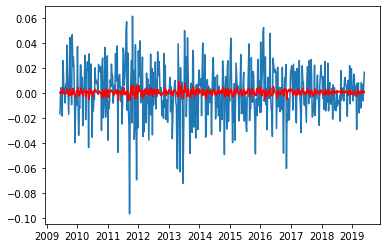

In [19]:
model = ARIMA(data_GLD_log, order=(2, 1, 1))  
results_ARIMA = model.fit(disp=-1)  
plt.plot(GLD_log_diff.index.to_pydatetime(), GLD_log_diff.values)
plt.plot(GLD_log_diff.index.to_pydatetime(), results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-GLD_log_diff)**2))


### 5.2 Measure the variance between the data and the values predicted by the model
"You can measure whether the results of your model fit the underlying data by using the residual sum of squares (RSS) metric. A small RSS indicates that the model fits tightly to the data.

Yet another approach to validate the ARIMA model appropriateness is by performing residual analysis.

Print the results of the ARIMA model and plot the residuals. A density plot of the residual error values indicates a normal distribution centered around zero mean. Also, the residuals do not violate the assumptions of constant location and scale with most values in the range (-1,1)."

                             ARIMA Model Results                              
Dep. Variable:            D.Adj_Close   No. Observations:                  521
Model:                 ARIMA(2, 1, 1)   Log Likelihood                1283.450
Method:                       css-mle   S.D. of innovations              0.021
Date:                Tue, 27 Aug 2019   AIC                          -2556.900
Time:                        02:00:34   BIC                          -2535.622
Sample:                    06-08-2009   HQIC                         -2548.565
                         - 05-27-2019                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0005      0.001      0.623      0.534      -0.001       0.002
ar.L1.D.Adj_Close     0.6891      0.408      1.691      0.092      -0.110       1.488
ar.L2.D.Adj_Close    -0.

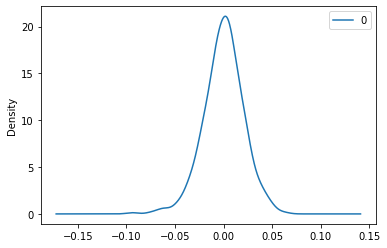

In [20]:
print(results_ARIMA.summary())
# plot residual errors
residuals = DataFrame(results_ARIMA.resid)
residuals.plot(kind='kde')
print(residuals.describe())

The model validation checks you ran have confirmed good results.

### 5.3 Scale predictions
Now that the model is returning the results you want to see, you can scale the model predictions back to the original scale. For this, you will remove the first order differencing and take exponent to restore the predictions back to their original scale.

The lower the root mean square error (RMSE) and the closer it is to 0, the better are the model predictions in being closer to actual values.

In [21]:
GLD_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print (GLD_ARIMA_diff.head())

Date
2009-06-08    0.000528
2009-06-15   -0.000724
2009-06-22    0.001191
2009-06-29    0.001558
2009-07-06   -0.000093
dtype: float64


In [22]:
GLD_ARIMA_diff_cumsum = GLD_ARIMA_diff.cumsum()
GLD_ARIMA_log = pd.Series(data_GLD_log.iloc[0], index=data_GLD_log.index)
GLD_ARIMA_log = GLD_ARIMA_log.add(GLD_ARIMA_diff_cumsum,fill_value=0)


ValueError: Cannot add integral value to Timestamp without freq.

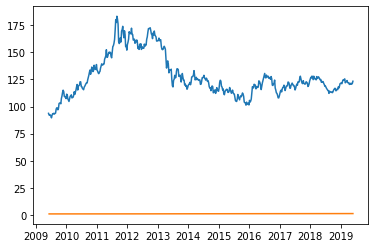

In [23]:
GLD_ARIMA_diff = np.exp(GLD_ARIMA_log)
plt.plot(data_GLD.index.to_pydatetime(), data_GLD.values)
plt.plot(data_GLD.index.to_pydatetime(), GLD_ARIMA_diff.values)
plt.title('RMSE: %.4f'% np.sqrt(sum((GLD_ARIMA_diff-data_GLD)**2)/len(data_GLD)))




"""
The RMSE is close enough to 0: the model predictions are accurate.


### 6. Perform and visualize time series forecasting
So far is in-sample forecasting using ARIMA as you trained the model on the entire time series data. Now you need to split the data set into a training and testing data sets. You will use the training data set to train the ARIMA model and perform out-of-sample forecasting. Then you will compare the results of your out-of-sample predictions for asset price with the actual values from the test data set.

You will use the forecast function forecast and perform a rolling one-step forecast with ARIMA. A rolling forecast is required given the dependence on observations during differencing and the AR model. You will re-create the ARIMA model after each new prediction is received. And you will manually keep track of all observations in a list called history, which is seeded with the training data and to which new predictions are appended in each iteration."""

In [28]:
historical = [x for x in train_data]
predictions = list()

print('Printing Predicted vs Expected Values...')
print('\n')
for t in range(len(test_data)):
    model = ARIMA(historical, order=(10,1,2))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(float(yhat))
    observed = test[t]
    historical.append(observed)
    print('Predicted Euro Rate = %f, Expected Euro Rate = %f' % (np.exp(yhat), np.exp(observed)))

error = mean_squared_error(test, predictions)

print('\n')
print('Printing Mean Squared Error of Predictions...')
print('Test MSE: %.6f' % error)

euro_predictions_series = pd.Series(predictions, index = test.index)

Printing Predicted vs Expected Values...




ValueError: Insufficient degrees of freedom to estimate

In [ ]:
train_ar = train_data['Adj_Close'].values
test_ar = test_data['Adj_Close'].values
history = [x for x in train_ar]
print(type(history))
predictions = list()
for t in range(len(test_ar)):
    model = ARIMA(history, order=(5,1,1))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test_ar[t]
    history.append(obs)
error = mean_squared_error(test_ar, predictions)
print('Testing Mean Squared Error: %.3f' % error)



Validated the model by comparing its out-of-sample predictions for Euro rates with actual values from the test data set and calculating the mean squared error. Now plot the rolling forecast predictions against the observed values. You will see that the predictions are in the correct scale and are picking up the trend in the original time series.

In [ ]:
fig, ax = plt.subplots()
ax.set(title='GLD Price in USD', xlabel='Date', ylabel='GLD in USD')
ax.plot(data_GLD[-50:], 'o', label='observed')
ax.plot(np.exp(euro_predictions_series), 'g', label='rolling one-step out-of-sample forecast')
legend = ax.legend(loc='upper left')
legend.get_frame().set_facecolor('w')



In [7]:
#scale MCD data

mm = MinMaxScaler()
scaled_GLD = mm.fit_transform(data_GLD)
print(data_GLD)
#%store scaled_MCD

             Adj_Close
Date                  
2009-06-01   93.709999
2009-06-08   92.169998
2009-06-15   91.900002
2009-06-22   92.290001
2009-06-29   91.250000
2009-07-06   89.580002
2009-07-13   91.930000
2009-07-20   93.410004
2009-07-27   93.349998
2009-08-03   93.750000
2009-08-10   93.000000
2009-08-17   93.650002
2009-08-24   93.870003
2009-08-31   97.529999
2009-09-07   98.779999
2009-09-14   98.669998
2009-09-21   97.000000
2009-09-28   98.370003
2009-10-05  102.839996
2009-10-12  103.180000
2009-10-19  103.489998
2009-10-26  102.529999
2009-11-02  107.430000
2009-11-09  109.739998
2009-11-16  112.940002
2009-11-23  115.059998
2009-11-30  113.750000
2009-12-07  109.320000
2009-12-14  108.949997
2009-12-21  108.360001
...                ...
2018-11-05  114.480003
2018-11-12  115.620003
2018-11-19  115.769997
2018-11-26  115.540001
2018-12-03  118.089996
2018-12-10  117.059998
2018-12-17  118.720001
2018-12-24  121.059998
2018-12-31  121.440002
2019-01-07  121.800003
2019-01-14 

In [8]:
#Change datasets to DataFrame
data_GLD_df = pd.DataFrame(data_GLD)
scaled_GLD_df = pd.DataFrame(scaled_GLD)

In [9]:
data_GLD_df.index

DatetimeIndex(['2009-06-01', '2009-06-08', '2009-06-15', '2009-06-22',
               '2009-06-29', '2009-07-06', '2009-07-13', '2009-07-20',
               '2009-07-27', '2009-08-03',
               ...
               '2019-03-25', '2019-04-01', '2019-04-08', '2019-04-15',
               '2019-04-22', '2019-04-29', '2019-05-06', '2019-05-13',
               '2019-05-20', '2019-05-27'],
              dtype='datetime64[ns]', name='Date', length=522, freq=None)

In [10]:
train_data, test_data = data_GLD_df[0:int(len(data_GLD_df)*0.6)], data_GLD_df[int(len(data_GLD_df)*0.6):]


In [12]:
train_ar = train_data['Adj_Close'].values
test_ar = test_data['Adj_Close'].values
history = [x for x in train_ar]
print(type(history))
predictions = list()
for t in range(len(test_ar)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test_ar[t]
    history.append(obs)
error = mean_squared_error(test_ar, predictions)
print('Testing Mean Squared Error: %.3f' % error)

<class 'list'>
Testing Mean Squared Error: 4.100


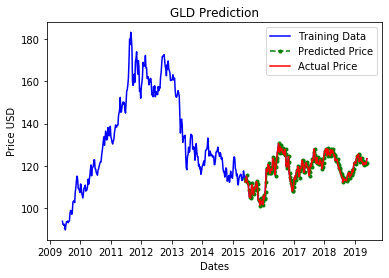

In [13]:
plt.plot(data_GLD_df['Adj_Close'], 'green', color='blue', label='Training Data')
plt.plot(test_data.index, predictions, color='green', marker='.', linestyle='dashed', 
         label='Predicted Price')
plt.plot(test_data.index, test_data['Adj_Close'], color='red', label='Actual Price')
plt.title('GLD Prediction')
plt.xlabel('Dates')
plt.ylabel('Price USD')
plt.legend()